In [2]:
import tifffile as tf
import pandas as pd
import numpy as np
from skimage.transform import hough_circle, hough_circle_peaks
from matplotlib import pyplot as plt
from skimage.filters import threshold_otsu
from skimage.draw import circle_perimeter

# Visualise an example


In [12]:
%matplotlib qt
fig, ax = plt.subplots(1,2)
names = ['NBD','LissRhod']
for i in range(images.shape[0]):
    ax[i].imshow(images[i],)
    ax[i].set_title(names[i])

# Threshold
## This is done as the GUV in the liss rhod channel is much brighter than the background

In [4]:
def create_bin_edges(image):
    bin_image = np.zeros_like(image)
    # threshold = threshold_otsu(images[1])
    threshold = np.mean(image)+ 3*np.std(image)
    bin_image[image> threshold ] = 1
    return bin_image

# Filter peaks for multiple detections
## This is achieved by setting an overlap threshold between pairs of peaks below which the two detections are considered to be from the same true peak.


### Firstly, we don't expect to find more than 8 guvs in one image for example. so we clip the detections to the top 8 detections

In [5]:
def clip_detections(accums,cx,cy,radii,N=8):
    accums = accums[:N]
    cx = cx[:N]
    cy = cy[:N]
    radii = radii[:N]
    return accums,cx,cy,radii


In [6]:
def find_duplicates(cxcy):
    #cxcy -> ndarray of shape (N_detections,2): initial detected centre coordinates of circles
    
    for i in range(cxcy.shape[0]):
        peak = cxcy[i]
        rest  = cxcy[i+1:]

        dists = np.linalg.norm(rest - peak,axis = 1)
        if i == 0:

            multi_detections = np.nonzero(dists < 20)[0] +i+1
            
        else:
            multi_detections = np.concatenate((multi_detections,np.nonzero(dists < 20)[0]+i+1))

    return np.unique(multi_detections)

    

In [7]:
def remove_duplicates(accum,cx,cy,radii,duplicate_coords):
    #accum -> 1darray: ordered results of voting on hough circles
    #cx -> 1darray: most likely x coords by voting
    #cy -> 1darray: most likely y coords by voting
    #duplicate_coords -> 1darray: indices of duplicate detections to remove
    
    accum = np.delete(accum,duplicate_coords)
    cx = np.delete(cx,duplicate_coords)
    cy = np.delete(cy,duplicate_coords)
    radii = np.delete(radii,duplicate_coords)
    return accum,cx,cy,radii

In [9]:

def segment_detections(image,hough_vals):
    #image -> ndarray (512,512): raw image 
    #hough_vals -> tuple of 4 1d_arrays : post processed hough circle detection
    ##############  (accumulator,c_x,c_y,radii)
    
    
    detections_img  = np.zeros_like(image)
    i = 1
    for x,y, rad in zip(hough_vals[1],hough_vals[2],hough_vals[3]):

        circy,circx = circle_perimeter(y,x,rad)
        detections_img[circy[circx < 512][circy[circx <512] < 512],circx[circx < 512][circy[circx<512] < 512]] = i
        i +=1
    # plt.imshow(images[1])
    # plt.imshow(detections_img,alpha=1)

    return detections_img




# Create dictionary of guv membrane Intensities for both NBD and LissRhod

In [10]:
#configurations
radii = np.arange(5,30,3)
N = 8

In [11]:


def getFretvals(image_directory,N_image,radii,N=8):
    
    
    membrane_intensities={}
    guv_radii = {}
    
    for frame in range(10,N_image):
        frame = str(frame)
        if len(frame)==1:
            frame = '0'+str(frame)
        try:
            tif = tf.TiffFile(image_directory+'/tifs/Image00'+frame+'.tif')
        except FileNotFoundError:
            continue
        images = tif.asarray()

        #create binary edges for circle detection
        bin_image = create_bin_edges(images[1])

        #circle detection with Hough transform

        hough_res = hough_circle(bin_image,radii)

        hough_vals = hough_circle_peaks(hough_res,radii)

        #clip detections: we don't expect there to be more than a few GUVs in one frame

        hough_vals = clip_detections(*hough_vals,N)

        #reshape the peak coordinates to exploit some numpy optimizations

        cxcy = np.vstack((hough_vals[1],hough_vals[2])).T

        #Due to bug in scikit image hough circle peaks function, need to remove duplicates

        duplicates = find_duplicates(cxcy)

        hough_vals = remove_duplicates(*hough_vals,duplicates)

        #Segment instances of circles to get individual GUV membranes

        detections_img = segment_detections(images[1],hough_vals)

        for _id in np.unique(detections_img):
            membrane_intensities[frame+'_'+str(_id)] = [np.mean(images[0][detections_img==_id]),np.mean(images[1][detections_img == _id])]
            guv_radii[frame+'_'+str(_id)] = len(detections_img[detections_img==_id])/(2*np.pi)
            
            
    return membrane_intensities,guv_radii



In [12]:
membrane_intensities10dot75,guv_radii10dot75 = getFretvals('/home/marcus/20200828_FRET_NBD_CALIB1pcNBD_0dot75pc_lissrhod/',55,radii)

In [13]:
membrane_intensities11,guv_radii11 = getFretvals('/home/marcus/20200827_NBDFRET_CALIB_1pcNBD1pcLissRhod/',32,radii)

# Use numpy indexing to filter GUV detections by radius

In [14]:
frets1to0dot75 = {}
for key in membrane_intensities10dot75.keys():
    frets1to0dot75[key] = membrane_intensities10dot75[key][1]/membrane_intensities10dot75[key][0]

In [15]:
frets11 = {}
for key in membrane_intensities11.keys():
    frets11[key] = membrane_intensities11[key][1]/membrane_intensities11[key][0]

In [16]:
frets11data = np.array(list(frets11.values()))
frets11keys = np.array(list(frets11.keys()))
radii11data = np.array(list(guv_radii11.values()))

In [17]:
frets75data = np.array(list(frets1to0dot75.values()))
frets75keys = np.array(list(frets1to0dot75.keys()))
radii75data=np.array(list(guv_radii10dot75.values()))

In [18]:
frets11data = frets11data[radii11data < 30]
frets11keys = frets11keys[radii11data < 30]
radii11data = radii11data[radii11data < 30]

frets11data = frets11data[radii11data >= 15]
frets11keys = frets11keys[radii11data >= 15]
radii11data = radii11data[radii11data >= 15]

In [19]:
frets75data = frets75data[radii75data < 30]
frets75keys = frets75keys[radii75data < 30]
radii75data = radii75data[radii75data < 30]

frets75data = frets75data[radii75data >= 15]
frets75keys = frets75keys[radii75data >= 15]
radii75data = radii75data[radii75data >= 15]

Text(0.5, 0, 'FRET ratio')

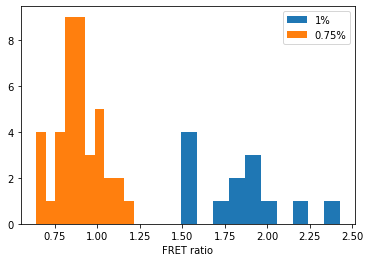

In [23]:
%matplotlib inline
plt.hist(frets11data,10)
plt.hist(frets75data,10)
plt.legend(['1%','0.75%'])
plt.xlabel('FRET ratio')

Text(0, 0.5, 'FRET ratio')

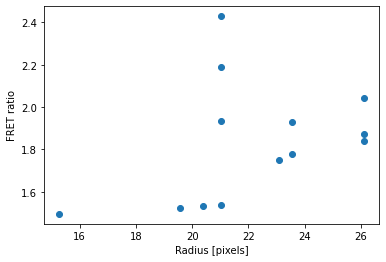

In [25]:
plt.scatter(radii11data,frets11data)
plt.xlabel('Radius [pixels]')
plt.ylabel('FRET ratio')